# 0-Zero-Shot-Mutation-Cancer-Hotspot

Objective: evaluate the models ability to classify known cancer-associated mutations.

## Prerequisites

Run [00-Mutation-Datasets-Preprocessing.ipynb](./00-Mutation-Datasets-Preprocessing.ipynb) to download required data `alphamissense_cancer_hotspot_processed.csv`.

## Dataset Information
- **Dataset**: Cancer Hotspot
- **Path**: `/data/processed/mutation_datasets_latest/alphamissense_cancer_hotspot_processed.csv`
- **Task**: Zero-shot mutation effect prediction
- **Models**: Pretrained Encodon models (80M, 600M, 1B)
- **Evaluation**: Binary classification (pathogenic vs benign). ROC-AUC and PR-AUC metrics.

### Key Features
- Binary classification (pathogenic vs benign)

## 1. Import Libraries

In [1]:
import os
import pickle
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl
import torch
from tqdm import tqdm


warnings.filterwarnings("ignore")

# Machine learning libraries
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, precision_recall_curve, roc_curve


plt.style.use("default")
sns.set_palette("husl")

# Add project paths
sys.path.append("../")

# Import Encodon-specific modules
from src.data.metadata import MetadataFields
from src.data.mutation_dataset import MutationDataset, collate_fn
from src.data.preprocess.mutation_pred import mlm_process_item
from src.inference.encodon import EncodonInference
from src.inference.task_types import TaskTypes


print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name()}")

✅ All libraries imported successfully!
PyTorch version: 2.8.0a0+34c6371d24.nv25.08
CUDA available: True
GPU device: NVIDIA RTX A6000


## 2. Load Encodon Models

In [ ]:
# Define checkpoint paths to try (update these to your actual paths!!!)
checkpoint_paths = {
    "80M": "/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1",
    "600m": "/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1",
    "1B": "/data/checkpoints/NV-CodonFM-Encodon-TE-Cdwt-1B-v1",
}
from src.utils.load_checkpoint import download_checkpoint


# download models if necessary
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-80M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-600M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-1B-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-1B-v1"
)

In [ ]:
def load_encodon_inference_model(checkpoint_path: str, device: str = "cuda") -> EncodonInference:
    """
    Load pretrained Encodon model using the inference wrapper.

    Args:
        checkpoint_path: Path to the pretrained checkpoint
        device: Device to load model on ('cuda' or 'cpu')

    Returns:
        EncodonInference object ready for mutation prediction
    """
    print(f"Loading Encodon model from: {checkpoint_path}")

    # Create inference wrapper
    inference_model = EncodonInference(
        model_path=checkpoint_path, use_transformer_engine=True, task_type=TaskTypes.MUTATION_PREDICTION
    )

    # Configure the model (loads checkpoint and tokenizer)
    inference_model.configure_model()
    inference_model.eval()

    print(f"✅ Model loaded successfully on {device}")
    print(f"Model parameters: {sum(p.numel() for p in inference_model.model.parameters()):,}")
    print(f"Tokenizer vocabulary size: {inference_model.tokenizer.vocab_size}")

    return inference_model


model_loaded = False
encodon_models = {}

for size, checkpoint_path in checkpoint_paths.items():
    if os.path.exists(checkpoint_path):
        try:
            device = "cuda" if torch.cuda.is_available() else "cpu"
            model = load_encodon_inference_model(checkpoint_path, device=device)

            # Extract model name from path
            model_name = os.path.basename(os.path.dirname(os.path.dirname(checkpoint_path)))
            display_name = f"EnCodon ({size})"

            encodon_models[display_name] = {"model": model, "path": checkpoint_path, "device": device}
            print(f"✅ Successfully loaded {display_name} from: {checkpoint_path}")
            model_loaded = True
        except Exception as e:
            print(f"Failed to load from {checkpoint_path}: {e}")
            continue

if not model_loaded:
    print("❌ Could not load any Encodon model from the specified paths.")
    print("Please ensure a checkpoint exists or update the checkpoint_paths list.")
else:
    print(f"\n✅ Loaded {len(encodon_models)} models: {list(encodon_models.keys())}")

## 3. Define Plotting Functions

In [3]:
def _assign_bar_colors(plot_data):
    """Assign unique colors to each bar based on model size (matching generate_results.py)."""
    # Colors for EnCodon models (matching the provided figure)
    encodon_colors = {
        "80M": (0.0, 0.4, 0.8),  # Blue
        "600M": (1.0, 0.5, 0.0),  # Orange
        "1B": (0.0, 0.7, 0.0),  # Green
    }

    colors = []
    for i, (model_name, auc, size_str, model_type) in enumerate(plot_data):
        if model_type == "encodon":
            color = encodon_colors.get(size_str, (0.5, 0.5, 0.5))
        else:
            color = (0.5, 0.5, 0.5)
        colors.append(color)
    return colors


def calculate_mutation_metrics(df, model_columns):
    """Calculate ROC-AUC and PR-AUC metrics for mutation models."""
    metrics = {}
    for model_name, col in model_columns.items():
        predictions = df[col]
        true_labels = df["pathogenicity_label"]

        # ROC-AUC
        fpr, tpr, _ = roc_curve(true_labels, predictions)
        roc_auc_value = auc(fpr, tpr)

        # PR-AUC
        precision, recall, _ = precision_recall_curve(true_labels, predictions)
        pr_auc_value = auc(recall, precision)

        metrics[model_name] = {
            "roc_auc": roc_auc_value,
            "pr_auc": pr_auc_value,
            "fpr": fpr,
            "tpr": tpr,
            "precision": precision,
            "recall": recall,
        }
    return metrics


def plot_results(metrics, dataset_name, save_prefix):
    """Create comprehensive plots for the results."""
    # Set up plot style
    sns.set_theme(style="whitegrid")

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f"{dataset_name} - Encodon Model Performance", fontsize=16, fontweight="bold")

    # Generate colors for models
    models_to_plot = list(metrics.keys())
    palette = sns.color_palette("tab10", len(models_to_plot))
    model_colors = dict(zip(models_to_plot, palette))

    # ROC curve
    ax1 = axes[0]
    for model in models_to_plot:
        model_metrics = metrics[model]
        ax1.plot(
            model_metrics["fpr"],
            model_metrics["tpr"],
            label=f"{model} (AUC = {model_metrics['roc_auc']:.3f})",
            color=model_colors.get(model, "black"),
            linewidth=2,
        )

    ax1.set_xlabel("False Positive Rate", fontsize=12)
    ax1.set_ylabel("True Positive Rate", fontsize=12)
    ax1.set_title("ROC Curves", fontsize=14, fontweight="bold")
    ax1.grid(True, linestyle="--", alpha=0.7)
    ax1.legend(loc="lower right", frameon=True, framealpha=0.9, fontsize=10)

    # PR curve
    ax2 = axes[1]
    for model in models_to_plot:
        model_metrics = metrics[model]
        ax2.plot(
            model_metrics["recall"],
            model_metrics["precision"],
            label=f"{model} (AUC = {model_metrics['pr_auc']:.3f})",
            color=model_colors.get(model, "black"),
            linewidth=2,
        )

    ax2.set_xlabel("Recall", fontsize=12)
    ax2.set_ylabel("Precision", fontsize=12)
    ax2.set_title("Precision-Recall Curves", fontsize=14, fontweight="bold")
    ax2.grid(True, linestyle="--", alpha=0.7)
    ax2.legend(loc="lower left", frameon=True, framealpha=0.9, fontsize=10)

    # Bar plot
    ax3 = axes[2]
    models = list(metrics.keys())

    def get_size_key(model):
        """Helper to determine model size from its name."""
        name = model.lower()
        if "80m" in name:
            return (1, "80M")
        elif "600m" in name:
            return (2, "600M")
        elif "1b" in name:
            return (3, "1B")
        else:
            return (99, "Unknown")

    # Prepare plot data
    plot_data = []
    for m in models:
        size_str = get_size_key(m)[1]
        plot_data.append((m, metrics[m]["roc_auc"], size_str, "encodon"))

    # Sort by size then by performance
    plot_data.sort(key=lambda x: (get_size_key(x[0])[0], -x[1]))
    colors = _assign_bar_colors(plot_data)

    x_positions = np.arange(len(plot_data))
    aucs = [auc for _, auc, _, _ in plot_data]
    bars = ax3.bar(x=x_positions, height=aucs, color=colors, edgecolor="black", linewidth=1.0, alpha=1.0)

    # Annotate bars
    for i, (model_name, auc_val, _, _) in enumerate(plot_data):
        ax3.text(i, bars[i].get_height() + 0.02, f"{auc_val:.3f}", ha="center", va="bottom", fontsize=9, color="black")

    ax3.set_xticks(x_positions)
    ax3.set_xticklabels([model_name for model_name, _, _, _ in plot_data], rotation=30, ha="right", fontsize=10)
    ax3.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
    ax3.set_xlabel("Model", fontsize=12)
    ax3.set_ylabel("AUROC", fontsize=12)
    ax3.set_ylim(0, max(aucs) + 0.1 if aucs else 1.0)
    ax3.grid(True, linestyle="-", alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_results.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()


print("✅ Plotting functions defined!")

✅ Plotting functions defined!


## 4. Load Cancer Hotspot Dataset

In [4]:
# Load CanncerHotspot dataset
DATASET_CONFIG = {
    "name": "CancerHotspot",
    "data_path": "/data/processed/mutation_datasets_latest/alphamissense_cancer_hotspot_processed.csv",
    "description": "",
}


def load_dataset(config):
    """Load and inspect the Cancer Hotspot dataset."""
    print(f"Loading {config['name']} dataset...")
    print(f"Path: {config['data_path']}")

    if not os.path.exists(config["data_path"]):
        print(f"❌ Dataset not found: {config['data_path']}")
        return None

    try:
        # Load data using polars then convert to pandas
        data = pl.read_csv(config["data_path"], ignore_errors=True).to_pandas()
        print(f"✅ Loaded {len(data)} variants")
        print(f"Shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")

        # Check for required columns
        required_cols = ["id", "ref_seq", "ref_codon", "alt_codon", "codon_position"]
        missing_cols = [col for col in required_cols if col not in data.columns]

        if missing_cols:
            print(f"⚠️ Missing columns: {missing_cols}")
        else:
            print("✅ All required columns present")

        # Handle labels based on dataset type
        data["pathogenicity_label"] = data["label"]
        label_counts = data["pathogenicity_label"].value_counts()
        print(f"Labels: {dict(label_counts)}")

        # Show sample data
        display_cols = [
            col for col in ["id", "ref_codon", "alt_codon", "codon_position", "label"] if col in data.columns
        ]
        print("\nSample data:")
        print(data[display_cols].head(3))
        return data

    except Exception as e:
        print(f"❌ Failed to load dataset: {e}")
        return None


# Load the dataset
dataset = load_dataset(DATASET_CONFIG)
print(f"\n📊 Dataset loaded: {dataset is not None}")

Loading CancerHotspot dataset...
Path: /data/validation/processed/alphamissense_cancer_hotspot_processed.csv
✅ Loaded 2601 variants
Shape: (2601, 27)
Columns: ['id', 'variant_id', 'transcript_id', 'protein_variant', 'AlphaMissense', 'label', 'chrom', 'pos', 'ref', 'alt', 'tx_name', 'cdsStart', 'cdsEnd', 'tx_strand', 'var_rel_dist_in_cds', 'ref_seq', 'ref_codon', 'alt_codon', 'ref_aa', 'alt_aa', 'alt_seq', 'codon_position', 'index_y', 'transcript_id_y', 'protein_variant_y', 'AlphaMissense_y', 'label_y']
✅ All required columns present
Labels: {0: 1733, 1: 868}

Sample data:
   id ref_codon alt_codon  codon_position  label
0   0       GAG       AAG              51      0
1   1       TAT       TGT              60      0
2   2       ACG       ATG              70      0

📊 Dataset loaded: True


## 5. Run Mutation Predictions

In [5]:
def run_mutation_predictions(models, data):
    """Run mutation predictions for Cancer Hotspot dataset."""
    if data is None or not models:
        print("❌ No data or models available")
        return {}

    print("\n=== RUNNING MUTATION PREDICTIONS FOR Cancer Hotspot ===")

    data_subset = data.copy()
    all_predictions = {}

    for model_name, model_info in models.items():
        print(f"\n--- Processing {model_name} ---")

        # Create temporary CSV file
        temp_csv_path = f"/tmp/cancer_hotspot_{model_name.replace(' ', '_')}_temp.csv"
        data_subset.to_csv(temp_csv_path, index=False)

        try:
            # Create MutationDataset
            mutation_dataset = MutationDataset(
                data_path=temp_csv_path,
                tokenizer=model_info["model"].tokenizer,
                process_item=mlm_process_item,
                context_length=2048,
                task="mlm",
                extract_seq=True,
                train_val_test_ratio=None,
            )

            # Create DataLoader
            dataloader = torch.utils.data.DataLoader(
                mutation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=0
            )

            # Run predictions
            all_ids = []
            all_likelihood_ratios = []

            model_info["model"].eval()
            model_info["model"].to(model_info["device"])
            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"{model_name} predictions"):
                    # Move batch to device
                    for key in batch:
                        if isinstance(batch[key], torch.Tensor):
                            batch[key] = batch[key].to(model_info["device"])

                    # Get predictions
                    output = model_info["model"].predict_mutation(batch, ids=batch[MetadataFields.ID])

                    all_ids.extend(output.ids)
                    all_likelihood_ratios.extend(output.likelihood_ratios)

            all_predictions[model_name] = {
                "ids": np.array(all_ids),
                "likelihood_ratios": np.array(all_likelihood_ratios),
            }
            print(f"✅ Completed {len(all_ids)} predictions")
            print(
                f"Likelihood ratio range: [{np.min(all_likelihood_ratios):.3f}, {np.max(all_likelihood_ratios):.3f}]"
            )
        except Exception as e:
            print(f"❌ Failed predictions for {model_name}: {e}")
            continue
        finally:
            # Clean up
            if os.path.exists(temp_csv_path):
                os.remove(temp_csv_path)

    return all_predictions


# Run predictions if models and dataset are available
if "encodon_models" in locals() and "dataset" in locals() and dataset is not None:
    predictions = run_mutation_predictions(encodon_models, dataset)
    print(f"\n✅ Predictions completed for {len(predictions)} models")
else:
    print("❌ Cannot run predictions - missing models or dataset")
    predictions = {}


=== RUNNING MUTATION PREDICTIONS FOR Cancer Hotspot ===

--- Processing EnCodon (80M) ---


EnCodon (80M) predictions: 100%|████████████████████████████████████████████████████████████████████| 82/82 [01:15<00:00,  1.09it/s]


✅ Completed 2601 predictions
Likelihood ratio range: [-9.203, 22.474]

--- Processing EnCodon (600m) ---


EnCodon (600m) predictions: 100%|███████████████████████████████████████████████████████████████████| 82/82 [05:06<00:00,  3.74s/it]


✅ Completed 2601 predictions
Likelihood ratio range: [-9.462, 23.057]

--- Processing EnCodon (1B) ---


EnCodon (1B) predictions: 100%|██████████████████| 82/82 [07:34<00:00,  5.54s/it]

✅ Completed 2601 predictions
Likelihood ratio range: [-7.298, 22.125]

✅ Predictions completed for 3 models


## 6. Evaluate Results


=== EVALUATING Cancer Hotspot RESULTS ===
EnCodon (80M): 2601/2601 variants (100.0%)
EnCodon (600m): 2601/2601 variants (100.0%)
EnCodon (1B): 2601/2601 variants (100.0%)

Evaluation set: 2601 variants with complete predictions

📊 Performance Summary:
  EnCodon (80M): ROC-AUC = 0.7361, PR-AUC = 0.5916
  EnCodon (600m): ROC-AUC = 0.7813, PR-AUC = 0.6258
  EnCodon (1B): ROC-AUC = 0.7939, PR-AUC = 0.6532


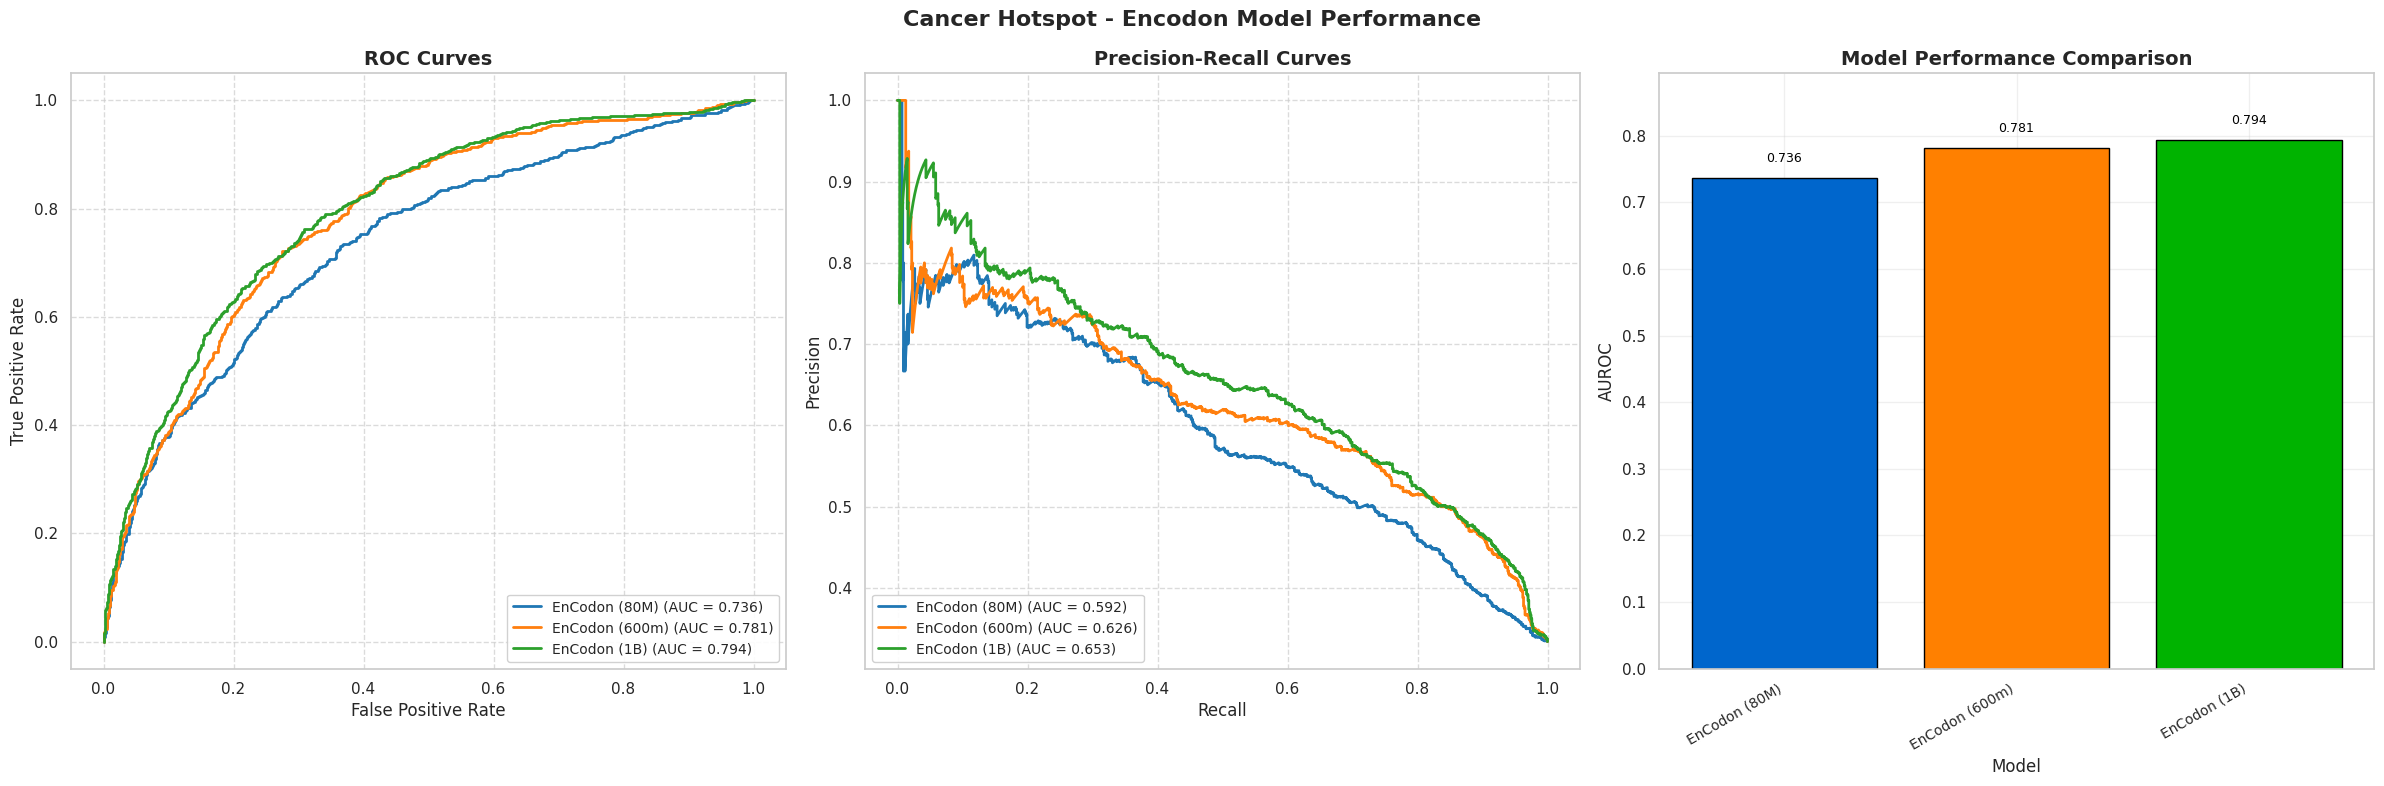

In [6]:
def evaluate_and_plot_cancer_hotspot_alphamissense_results(predictions, data):
    """Evaluate and plot results for Cancer Hotspot."""
    if not predictions or data is None:
        print("❌ No predictions or data available")
        return

    print("\n=== EVALUATING Cancer Hotspot RESULTS ===")

    # Check if we have pathogenicity labels for ROC/PR analysis
    if "pathogenicity_label" not in data.columns:
        print("⚠️ No pathogenicity labels found - skipping ROC/PR analysis")
        return

    # Create evaluation dataframe
    eval_df = data.copy()
    model_columns = {}

    for model_name, pred_data in predictions.items():
        # Create mapping from ID to likelihood ratio
        id_to_lr = dict(zip(pred_data["ids"], pred_data["likelihood_ratios"]))

        # Add predictions to dataframe
        col_name = f"likelihood_ratios_{model_name}"
        eval_df[col_name] = eval_df["id"].map(id_to_lr)
        model_columns[model_name] = col_name

        # Report coverage
        coverage = eval_df[col_name].notna().sum()
        print(f"{model_name}: {coverage}/{len(eval_df)} variants ({coverage / len(eval_df) * 100:.1f}%)")

    # Filter to complete cases
    mask = pd.Series(True, index=eval_df.index)
    for col in model_columns.values():
        mask &= ~eval_df[col].isna()

    eval_df_filtered = eval_df[mask]
    print(f"\nEvaluation set: {len(eval_df_filtered)} variants with complete predictions")

    # Calculate metrics
    metrics = calculate_mutation_metrics(eval_df_filtered, model_columns)

    # Print summary
    print("\n📊 Performance Summary:")
    for model_name in model_columns.keys():
        m = metrics[model_name]
        print(f"  {model_name}: ROC-AUC = {m['roc_auc']:.4f}, PR-AUC = {m['pr_auc']:.4f}")

    # Create plots
    plot_results(metrics, "Cancer Hotspot", "cancer_hotspot")

    return metrics


# Run evaluation
if "predictions" in locals() and "dataset" in locals():
    results = evaluate_and_plot_cancer_hotspot_alphamissense_results(predictions, dataset)
else:
    print("❌ No predictions or dataset available for evaluation")

## 7. Save/Load Results

In [7]:
def save_cancer_hotspot_results(predictions, filename="cancer_hotspot_results.pkl"):
    """Save CancerHotspot prediction results."""
    results_to_save = {
        "predictions": predictions,
        "dataset_key": "cancer_hotspot",
        "dataset_name": "CancerHotspot",
        "timestamp": datetime.now().isoformat(),
        "models": list(predictions.keys()) if predictions else [],
    }

    with open(filename, "wb") as f:
        pickle.dump(results_to_save, f)

    print(f"✅ CancerHotspot results saved to {filename}")
    print(f"   Models: {results_to_save['models']}")
    print(f"   Timestamp: {results_to_save['timestamp']}")


def load_cancer_hotspot_results(filename="cancer_hotspot_results.pkl"):
    """Load CancerHotspot prediction results."""
    if not os.path.exists(filename):
        print(f"❌ Results file not found: {filename}")
        return {}

    with open(filename, "rb") as f:
        results = pickle.load(f)

    print(f"✅ CancerHotspot results loaded from {filename}")
    print(f"   Models: {results.get('models', [])}")
    print(f"   Timestamp: {results.get('timestamp', 'Unknown')}")

    return results.get("predictions", {})


# Save current results if available
if "predictions" in locals() and predictions:
    save_cancer_hotspot_results(predictions)
    print("\n💾 CancerHotspot results saved!")
else:
    print("\n⚠️ No CancerHotspot results to save yet")

# Try to load existing results
if os.path.exists("cancer_hotspot_results.pkl"):
    saved_predictions = load_cancer_hotspot_results()
    if saved_predictions and not locals().get("predictions"):
        predictions = saved_predictions
        print("   Using saved results for analysis")

✅ CancerHotspot results saved to cancer_hotspot_results.pkl
   Models: ['EnCodon (80M)', 'EnCodon (600m)', 'EnCodon (1B)']
   Timestamp: 2025-10-22T15:16:19.097572

💾 CancerHotspot results saved!
✅ CancerHotspot results loaded from cancer_hotspot_results.pkl
   Models: ['EnCodon (80M)', 'EnCodon (600m)', 'EnCodon (1B)']
   Timestamp: 2025-10-22T15:16:19.097572
